<a href="https://colab.research.google.com/github/hnishi/jupyterbook-hnishi/blob/colab-dev/pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 主成分分析 （主成分解析、Principal component analysis : PCA）

## 概要

- 主成分分析は、教師なし線形変換法の１つ
  - データセットの座標軸を、データの分散が最大になる方向に変換し、元の次元と同じもしくは、元の次元数より低い新しい特徴部分空間を作成する手法
- 主なタスク
  - 次元削減
- 次元削減を行うことで以下の目的を達成できる
  - 特徴抽出
  - データの可視化
- 次元削減を行うメリット
  - 計算コスト（計算時間、メモリ使用量）を削減できる
  - 特徴量を削減したことによる情報の喪失をできるだけ小さくする
  - モデルを簡素化できる（パラメータが減る）ため、オーバーフィッティングを防げる
  - 人間が理解可能な空間にデータを投影することができる（非常に高次元な空間を、身近な3次元、2次元に落とし込むことができる）

## 応用例

- タンパク質分子の立体構造モデルの構造空間の次元削減と可視化
- タンパク質の全原子モデルの立体構造は、分子内に含まれる原子の座標情報で表すことができる （原子数 × 3 (x, y, z) 次元のベクトル）

以下は、タンパク質の分子シミュレーションで使われるモデルの1例。  
（紫色とオレンジ色で表されたリボンモデルがタンパク質で、周りに水とイオンが表示されている）  
（この場合、3547 個の原子 --> 10641 次元）

<img src="https://github.com/hnishi/hnishi_da_handson/blob/master/images/cdr-h3-pbc.png?raw=true" width="50%">

主成分分析により、この立体構造空間を、2次元空間に投影することができる。  
以下は、その投影に対して自由エネルギーを計算した図。

![pmf](https://github.com/hnishi/hnishi_da_handson/blob/dev/images/pmf.jpeg?raw=true)

2次元空間上の1点が、1つの立体構造を表している。  
つまり、この例では、もともと10641次元あった空間を2次元にまで削減している。

Ref) [Nishigami, H., Kamiya, N., & Nakamura, H. (2016). Revisiting antibody modeling assessment for CDR-H3 loop. Protein Engineering, Design and Selection, 29(11), 477-484.](https://academic.oup.com/peds/article/29/11/477/2462452)

## 主成分分析 (PCA) が行う座標変換のイメージ

以下は、PCAが行う座標変換の例

$x_1$ , $x_2$ は、データセットの元々の座標軸であり、  
PC1, PC2 は座標変換後に得られる新しい座標軸、主成分1、主成分2 である (Principal Components)。  



<img src="https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch05/images/05_01.png?raw=true" width="50%">


- PCA は、高次元データにおいて分散が最大となる方向を見つけ出し、座標を変換する （これはつまり、すべての主成分が、他の主成分と相関がない（直交する) ように座標変換している)
- 最初の主成分 (PC1) の分散が最大となる

## 主成分分析の主要な手順

d 次元のデータを k 次元に削減する場合

1. d 次元のデータの標準化（特徴量間のスケールが異なる場合のみ）
1. 分散共分散行列の作成
1. 分散共分散行列の固有値と固有ベクトルを求める
1. 固有値を降順にソートして、固有ベクトルをランク付けする
1. 最も大きい k 個の固有値に対応する k 個の固有ベクトルを選択 (k ≦ d)
1. k 個の固有ベクトルから射影(変換)行列 W を作成
1. 射影(変換)行列を使って d 次元の入力データセットを新しい k 次元の特徴部分空間を取得する

---

固有値問題を解くことで、線形独立な基底ベクトルを得ることができる。  
詳細は、線形代数の書籍等を参考にする（ここでは詳細な解説をしない）。

参考）  

https://dora.bk.tsukuba.ac.jp/~takeuchi/?%E7%B7%9A%E5%BD%A2%E4%BB%A3%E6%95%B0II%2F%E5%9B%BA%E6%9C%89%E5%80%A4%E5%95%8F%E9%A1%8C%E3%83%BB%E5%9B%BA%E6%9C%89%E7%A9%BA%E9%96%93%E3%83%BB%E3%82%B9%E3%83%9A%E3%82%AF%E3%83%88%E3%83%AB%E5%88%86%E8%A7%A3

## python による PCA の実行

以下、Python を使った PCA の実行を順番に見ていく。  
その後、scikit-learn ライブラリを使った PCA の簡単で効率のよい実装を見る。  

### データセット

- データセットは、 [Wine](https://archive.ics.uci.edu/ml/datasets/Wine) というオープンソースのデータセットを使う。  
- 178 行のワインサンプルと、それらの化学的性質を表す 13 列の特徴量で構成されている。
- それぞれのサンプルに、クラス 1, 2, 3 のいずれかがラベルされており、  
イタリアの同じ地域で栽培されている異なる品種のブドウを表している   
（PCA は教師なし学習なので、学習時にラベルは使わない）。


In [ ]:
from IPython.display import Image
%matplotlib inline

In [ ]:
import pandas as pd

# df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
#                       'machine-learning-databases/wine/wine.data',
#                       header=None)

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

df_wine = pd.read_csv('https://github.com/rasbt/python-machine-learning-book-2nd-edition'
                      '/raw/master/code/ch05/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Wine データセットの先頭 5 行のデータは上記。

In [ ]:
for i_label in df_wine['Class label'].unique():
  print('label:', i_label)
  print('shape:', df_wine[df_wine['Class label'] == i_label].shape)

label: 1
shape: (59, 14)
label: 2
shape: (71, 14)
label: 3
shape: (48, 14)


ラベルの数はおおよそ揃っている。  
次に、ラベルごとにデータの分布を見てみる。

feature: Alcohol


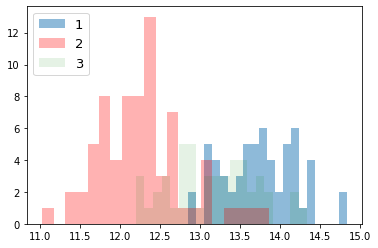

feature: Malic acid


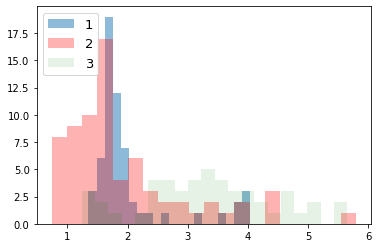

feature: Ash


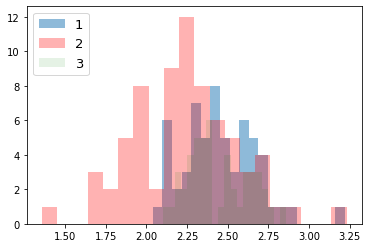

feature: Alcalinity of ash


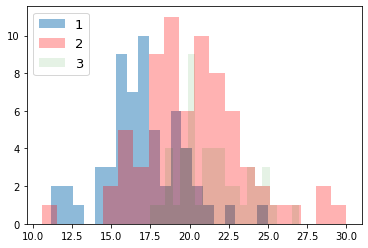

feature: Magnesium


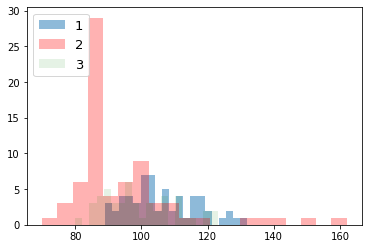

feature: Total phenols


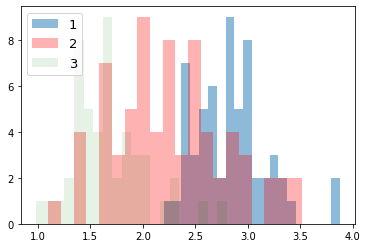

feature: Flavanoids


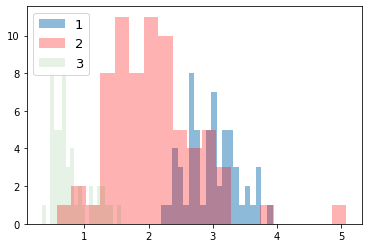

feature: Nonflavanoid phenols


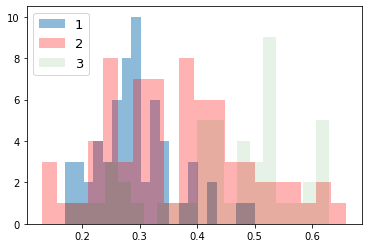

feature: Proanthocyanins


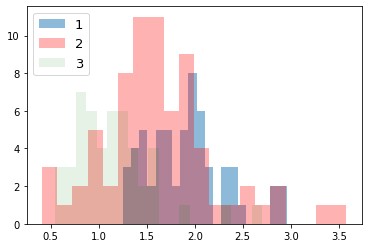

feature: Color intensity


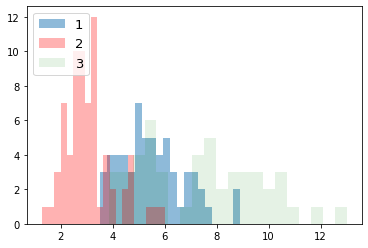

feature: Hue


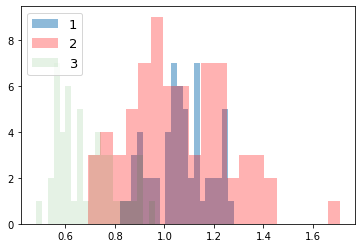

feature: OD280/OD315 of diluted wines


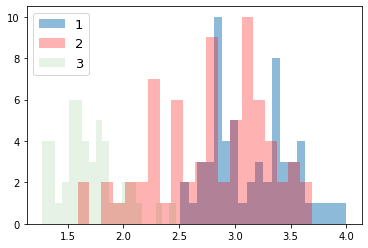

feature: Proline


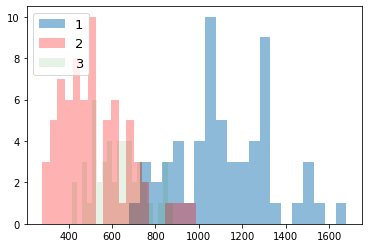

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for i_feature in df_wine.columns:
  if i_feature == 'Class label': continue
  print('feature: ' + str(i_feature))
  # ヒストグラムの描画
  plt.hist(df_wine[df_wine['Class label'] == 1][i_feature], alpha=0.5, bins=20, label="1") 
  plt.hist(df_wine[df_wine['Class label'] == 2][i_feature], alpha=0.3, bins=20, label="2", color='r')
  plt.hist(df_wine[df_wine['Class label'] == 3][i_feature], alpha=0.1, bins=20, label="3", color='g') 
  plt.legend(loc="upper left", fontsize=13) # 凡例表示
  plt.show()

データを70％のトレーニングと30％のテストサブセットに分割する。

In [ ]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

データの標準化を行う。

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train) # トレーニングセットの標準偏差と平均値を使って、標準化を行う
X_test_std = sc.transform(X_test) # "トレーニングセット"の標準偏差と平均値を使って、標準化を行う

# いずれの特徴量も、値がおおよそ、-1 から +1 の範囲にあることを確認する。
print('standardize train', X_train_std[0:2])
print('standardize test', X_test_std[0:2])

standardize train [[ 0.71225893  2.22048673 -0.13025864  0.05962872 -0.50432733 -0.52831584
  -1.24000033  0.84118003 -1.05215112 -0.29218864 -0.20017028 -0.82164144
  -0.62946362]
 [ 0.88229214 -0.70457155  1.17533605 -0.09065504  2.34147876  1.01675879
   0.66299475  1.0887425  -0.49293533  0.13152077  1.33982592  0.54931269
   1.47568796]]
standardize test [[ 0.89443737 -0.38811788  1.10073064 -0.81201711  1.13201117  1.09807851
   0.71204102  0.18101342  0.06628046  0.51285923  0.79629785  0.44829502
   1.90593792]
 [-1.04879931 -0.77299397  0.54119006 -0.24093881  0.3494145  -0.70721922
  -0.30812129  0.67613838 -1.03520519 -0.90656727  2.24570604 -0.56188171
  -1.22874035]]


---

**注意**

テストデータの標準化の際に、テストデータの標準偏差と平均値を用いてはいけない（トレーニングデータの標準偏差と平均値を用いること）。  
また、ここで求めた標準偏差と平均値は、未知のデータを標準化する際にも再使用するので、記録しておくこと。  
（今回は、ノートブックだけで完結するので、外部ファイル等に記録しなくても問題ない）  

- 分散共分散行列を作成
- 固有値問題を解いて、固有値と固有ベクトルを求める

固有値問題とは、以下の条件を満たす、固有ベクトル $v$ と、スカラー値である固有値 $\lambda$ を求める問題のことである  
（詳細は線形代数の書籍等を参考）。

$$\Sigma v=\lambda v$$

$\Sigma$ は分散共分散行列である（総和記号ではないことに注意）。  
  
分散共分散行列に関しては、 [前回の資料](https://github.com/hnishi/hnishi_da_handson/blob/master/da_handson_basic_statistic_values.ipynb) を参照。


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


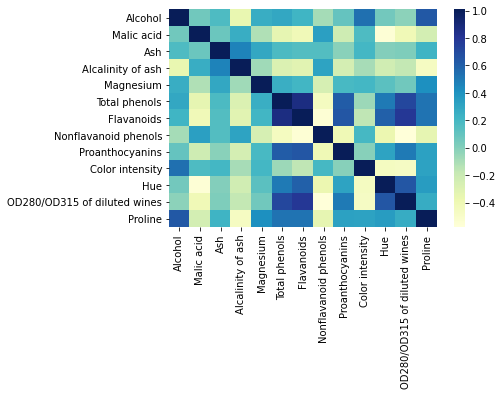

In [ ]:
import numpy as np
import seaborn as sns

cov_mat = np.cov(X_train_std.T)

# 共分散行列のヒートマップ
df = pd.DataFrame(cov_mat, index=df_wine.columns[1:], columns=df_wine.columns[1:])
ax = sns.heatmap(df, cmap="YlGnBu") 

In [ ]:
# 固有値問題を解く（固有値分解）
eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)
print('\nShape of eigen vectors\n', eigen_vecs.shape)


Eigenvalues 
[0.10754642 0.15362835 0.1808613  0.21357215 0.3131368  0.34650377
 0.51828472 0.6620634  0.84166161 0.96120438 1.54845825 2.41602459
 4.84274532]

Shape of eigen vectors
 (13, 13)


**注意**: 

固有値分解（固有分解とも呼ばれる）する numpy の関数は、

- [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html)
- [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) 

がある。  
`numpy.linalg.eig` は対称正方行列と非対称正方行列を固有値分解する関数。複素数の固有値を返すことがある。  
`numpy.linalg.eigh` はエルミート行列（各成分が複素数で、転置させた各成分の虚部の値の正負を反転させたものがもとの行列と等しくなる行列）を固有値分解する関数。常に実数の固有値を返す。  

分散共分散行列は、対称正方行列であり、虚数部が 0 のエルミート行列でもある。  
対称正方行列の操作では、`numpy.linalg.eigh` の方が数値的に安定しているらしい。

Ref) *Python Machine Learning 2nd Edition* by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2017.


## 全分散と説明分散（Total and explained variance）

- 固有値の大きさは、データに含まれる情報（分散）の大きさに対応している
- 主成分j (PCj: j-th principal component) に対応する固有値 $\lambda_j$ の分散説明率（寄与率、contribution ratio/propotion とも呼ばれる）は以下のように定義される。

$$\dfrac {\lambda _{j}}{\sum ^{d}_{j=1}\lambda j}$$ 

$\lambda_j$ は、j 番目の固有値、d は全固有値の数（元々の特徴量の数/次元数）。  

分散説明率を見ることで、その主成分が特徴量全体がもつ情報のうち、どれぐらいの情報を表すことができているかを確認できる。  
以下に、分散説明率と、その累積和をプロットする。

In [ ]:
# 固有値の合計
tot = sum(eigen_vals)
# 分散説明率の配列を作成
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
# 分散説明率の累積和を作成
cum_var_exp = np.cumsum(var_exp)

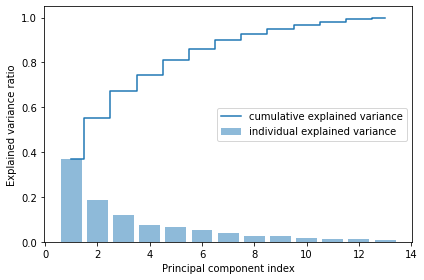

In [ ]:
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/05_02.png', dpi=300)
plt.show()

グラフから以下のことがわかる。

- 最初の主成分だけで、全体の約 4 割の分散を占めている
- 2 つの主成分も用いるだけで、もともとあった特徴量全体の約 6 割を説明できている

## 因子負荷量 (Factor loading)

各主成分軸の意味を知るためには、因子負荷量を見れば良い。
因子負荷量とは、主成分軸における値と、変換前の軸における値との間の相関値のことである。

この相関が大きくなるほど、その特徴量が、その主成分に寄与する程度が大きいということを意味している。

Ref: https://statistics.co.jp/reference/software_R/statR_9_principal.pdf

## 特徴変換 (Feature transformation)

射影（変換）行列を取得し、適用して特徴変換を行う。

---

$X' = XW$  

$X'$ : 射影（変換）後の座標（行列）  
$X$ : もともとの座標（行列）   
$W$ : 射影（変換）行列  
  
$W$ は、次元削減後の次元数の固有ベクトルから構成される。  

$W = [v_1 v_2 ... v_k] \in \mathbb{R} ^{n\times k}$  

In [ ]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

### まずは、次元削減を行わずに、13 次元 --> 13 次元の座標変換を見てみる

$X' = XW$  

$W = [v_1 v_2 ... v_13] \in \mathbb{R} ^{13\times 13}$  
$x \in \mathbb{R} ^{13}$    
$x' \in \mathbb{R} ^{13}$    

In [ ]:
# 変換行列 w の作成
w = eigen_pairs[0][1][:, np.newaxis]
for i in range(1, len(eigen_pairs)):
  # print(i)
  w = np.hstack((w, eigen_pairs[i][1][:, np.newaxis]))
w.shape

(13, 13)

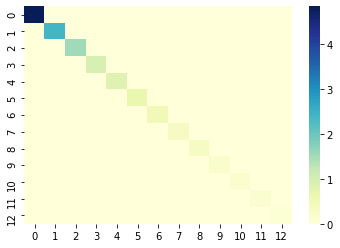

In [ ]:
# 座標変換
X_train_pca = X_train_std.dot(w)
# print(X_train_pca.shape)

cov_mat = np.cov(X_train_pca.T)

# 共分散行列のヒートマップ
df = pd.DataFrame(cov_mat)
ax = sns.heatmap(df, cmap="YlGnBu") 

主成分空間に変換後の各特徴量は、互いに相関が全くないことがわかる（互いに線形独立）。  
対角成分は分散値であり、第1主成分から大きい順に並んでいることがわかる。

### 座標変換された空間から元の空間への復元

## 座標変換された空間から元の空間への復元

$X = X'W^T$  

$X'$ : 座標変換後の座標（行列）  
$X$ : もともとの空間に復元された座標（行列）   
$W^T \in \mathbb{R} ^{n\times n}$ : 転置された変）行列  
   
$x' \in \mathbb{R} ^{n}$   
$x_{approx} \in \mathbb{R} ^{n}$   


In [ ]:
# 1つ目のサンプルに射影行列を適用（内積を作用させる）
x0 = X_train_std[0]
print('もともとの特徴量:', x0)
z0 = x0.dot(w)
print('変換後の特徴量:', z0)
x0_reconstructed = z0.dot(w.T)
print('復元された特徴量:', x0_reconstructed)

もともとの特徴量: [ 0.71225893  2.22048673 -0.13025864  0.05962872 -0.50432733 -0.52831584
 -1.24000033  0.84118003 -1.05215112 -0.29218864 -0.20017028 -0.82164144
 -0.62946362]
変換後の特徴量: [ 2.38299011  0.45458499  0.22703207  0.57988399 -0.57994169 -1.73317476
 -0.70180475 -0.21617248  0.23666876  0.16548767 -0.29726982 -0.23489704
  0.40161994]
復元された特徴量: [ 0.71225893  2.22048673 -0.13025864  0.05962872 -0.50432733 -0.52831584
 -1.24000033  0.84118003 -1.05215112 -0.29218864 -0.20017028 -0.82164144
 -0.62946362]


完全に復元できていることがわかる。

###  13 次元 --> 2 次元に次元削減する

$X' = XW$  

$W = [v_1 v_2] \in \mathbb{R} ^{13\times 2}$  
$x \in \mathbb{R} ^{13}$    
$x' \in \mathbb{R} ^{2}$    

In [ ]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


**注意**

NumPy と LAPACK のバージョンによっては、上記の例とは符号が反転した射影行列 w が作成されることがあるが、問題はない。  
以下の式が成り立つからである。  

行列 $\Sigma$ に対して、 $v$ が固有ベクトル、$\lambda$ が固有値のとき、  
$$\Sigma v = \lambda v,$$

ここで $-v$ もまた同じ固有値をもつ固有ベクトルとなる。  
$$\Sigma \cdot (-v) = -\Sigma v = -\lambda v = \lambda \cdot (-v).$$

(主成分軸のベクトルの向きの違い）

In [ ]:
# 各サンプルに射影行列を適用（内積を作用）させることで、変換後の座標（特徴量）を得ることができる。
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

### 2次元に射影後の全データを、ラベルごとに色付けしてプロットする

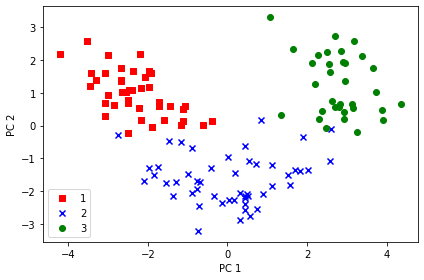

In [ ]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_03.png', dpi=300)
plt.show()

PC1 軸方向をみると、PC2 軸方向よりもよりもデータが広く分布しており、データをよりよく区別できていることがわかる。

## 次元削減された空間から元の空間への復元

$X_{approx} = X'W^T$  

$X'$ : 射影後の座標（行列）  
$X_{approx}$ : もともとの空間に、近似的に、復元された座標（行列）   
$W^T \in \mathbb{R} ^{n\times k}$ : 転置された射影（変換）行列  
   
$x' \in \mathbb{R} ^{k}$   
$x_{approx} \in \mathbb{R} ^{n}$   
  
$k = n$ のとき、$X = X_{approx}$ が成り立つ（上述）。

In [ ]:
# 1つ目のサンプルに射影行列を適用（内積を作用させる）
x0 = X_train_std[0]
print('もともとの特徴量:', x0)
z0 = x0.dot(w)
print('変換後の特徴量:', z0)
x0_reconstructed = z0.dot(w.T)
print('復元された特徴量:', x0_reconstructed)

もともとの特徴量: [ 0.71225893  2.22048673 -0.13025864  0.05962872 -0.50432733 -0.52831584
 -1.24000033  0.84118003 -1.05215112 -0.29218864 -0.20017028 -0.82164144
 -0.62946362]
変換後の特徴量: [2.38299011 0.45458499]
復元された特徴量: [-0.09837469  0.66412622  0.05052458  0.44153949 -0.23613841 -0.91525549
 -1.00494135  0.76968396 -0.72702683  0.42993247 -0.87134462 -0.9915977
 -0.53417827]


完全には復元できていないことがわかる（近似値に復元される）。

## Principal component analysis in scikit-learn

上記で行った PCA の実装は、scikit-learn を使うことで簡単に実装できる。
以下にその実装を示す。

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
# 主成分分析の実行
X_train_pca = pca.fit_transform(X_train_std)
# 分散説明率の表示
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

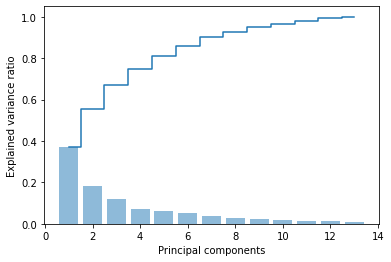

In [ ]:
# 分散説明率とその累積和のプロット
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [ ]:
# 2次元に削減
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

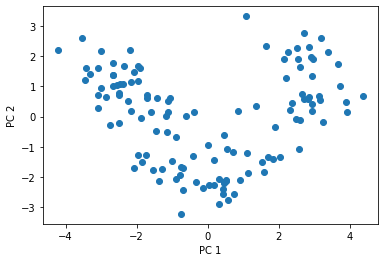

In [ ]:
# 2次元空間にプロット
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

### 因子負荷量の確認

以下のように、`pca.components_` を見ることで、因子負荷量を確認することができる。

In [ ]:
pd.DataFrame(pca.components_.T,index=df_wine.columns[1:],columns=['PC1','PC2']).sort_values('PC1')

,PC1,PC2
Flavanoids,-0.417351,-0.022873
Total phenols,-0.393770,0.050801
OD280/OD315 of diluted wines,-0.368610,-0.249025
Hue,-0.326133,-0.207164
Proanthocyanins,-0.306683,0.008352
Proline,-0.296697,0.380229
Magnesium,-0.154366,0.289745
Alcohol,-0.137242,0.503035
Ash,-0.025452,0.244565
Color intensity,0.075541,0.549776


値の絶対値が大きい特徴量を見れば良い。

つまり、第１主成分 (PC1) でよく表されている特徴量は、 "Flavanoids" と "Total phenols" である。
一方、第２主成分 (PC2) でよく表されている特徴量は、 "Color intensity" と "Alcohol" である。

## 2次元に次元削減された特徴量を用いてロジスティック回帰を行ってみる


In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

Training logistic regression classifier using the first 2 principal components.

In [ ]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(penalty='l2', C=1.0)
# lr = LogisticRegression(penalty='none')
lr = lr.fit(X_train_pca, y_train)

In [ ]:
print(X_train_pca.shape)

(124, 2)


In [ ]:
print('Cumulative explained variance ratio:', sum(pca.explained_variance_ratio_))

Cumulative explained variance ratio: 0.5538639565949177


### 学習時間の計測

In [ ]:
%timeit lr.fit(X_train_pca, y_train)

100 loops, best of 3: 5.08 ms per loop


accuracy 0.9838709677419355


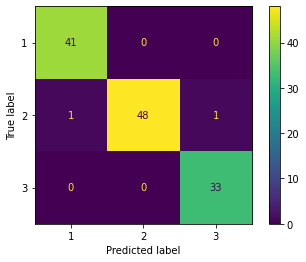

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# 精度
print('accuracy', lr.score(X_train_pca, y_train))
# confusion matrix
plot_confusion_matrix(lr, X_train_pca, y_train)

### トレーニングデータセットの予測結果

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


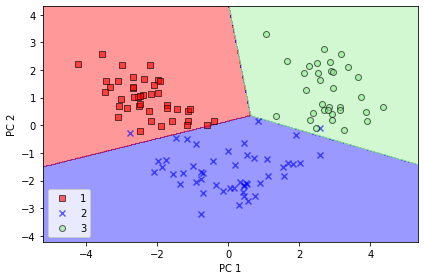

In [ ]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

### テストデータに対する予測結果

accuracy 0.9259259259259259


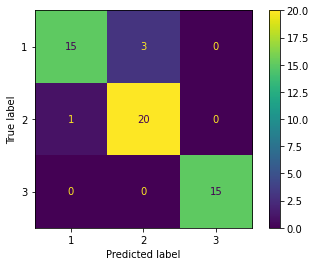

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# 精度
print('accuracy', lr.score(X_test_pca, y_test))
# confusion matrix
plot_confusion_matrix(lr, X_test_pca, y_test)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


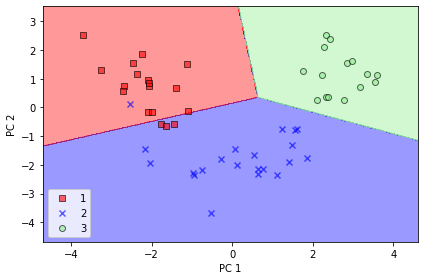

In [ ]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_05.png', dpi=300)
plt.show()

次元削減せずに全てのの主成分を取得したい場合は、 `n_components=None` にする。

In [ ]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

## 3 次元に次元削減された特徴量を用いてロジスティック回帰を行ってみる

In [ ]:
from sklearn.linear_model import LogisticRegression

k = 3

pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(penalty='l2', C=1.0)
# lr = LogisticRegression(penalty='none')
lr = lr.fit(X_train_pca, y_train)

In [ ]:
print(X_train_pca.shape)

(124, 3)


In [ ]:
print('Cumulative explained variance ratio:', sum(pca.explained_variance_ratio_))

Cumulative explained variance ratio: 0.6720155475408875


In [ ]:
%timeit lr.fit(X_train_pca, y_train)

100 loops, best of 3: 6.02 ms per loop


accuracy 0.9838709677419355


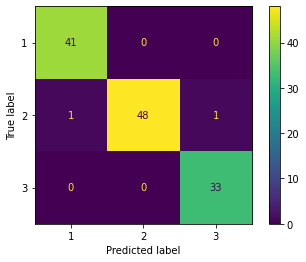

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# 精度
print('accuracy', lr.score(X_train_pca, y_train))
# confusion matrix
plot_confusion_matrix(lr, X_train_pca, y_train)

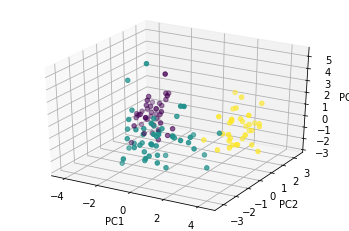

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(X_train_pca[:,0], X_train_pca[:,1], X_train_pca[:,2], c='r', marker='o')
ax.scatter(X_train_pca[:,0], X_train_pca[:,1], X_train_pca[:,2], c=y_train, marker='o')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

In [ ]:
# plotly を使った interactive な 3D 散布図
import plotly.express as px

df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2', 'PC3'])
df['label'] = y_train

fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
              color='label', opacity=0.7, )
fig.show()

人間の目で確認できるのは 3 次元が限界。

## 次元削減せずにロジスティック回帰を行ってみる



In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', C=1.0)
# lr = LogisticRegression(penalty='none')
lr = lr.fit(X_train_std, y_train)

In [ ]:
# 学習時間
%timeit lr.fit(X_train_std, y_train)

100 loops, best of 3: 7.24 ms per loop


Evaluation of training dataset
accuracy 1.0
Evaluation of test dataset
accuracy 1.0


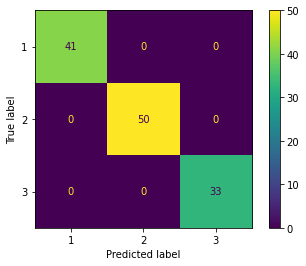

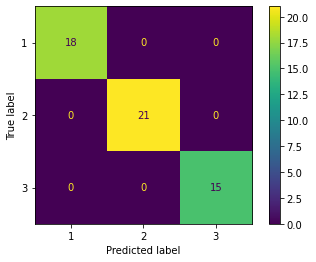

In [ ]:
from sklearn.metrics import plot_confusion_matrix

print('Evaluation of training dataset')
# 精度
print('accuracy', lr.score(X_train_std, y_train))
# confusion matrix
plot_confusion_matrix(lr, X_train_std, y_train)

print('Evaluation of test dataset')
# 精度
print('accuracy', lr.score(X_test_std, y_test))
# confusion matrix
plot_confusion_matrix(lr, X_test_std, y_test)

元々の全ての特徴量を使って学習させた方が精度が高くなった。  
学習時間は、次元削減したほうがわずかに早くなっている。
（主成分 2 つで学習した場合 4.9 ms に対し、元々の特徴量全て使った場合 5.64 ms）  
結論として、今回のタスクでは、PCA を適用するべきではなく、すべての特徴量を使用したほうが良い。  
  
もっとデータ数が大きい場合や、モデルのパラメータ数が多い場合には、次元削減が効果的となる。

### 2つの特徴量だけでロジスティック回帰を行ってみる



In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', C=1.0)
# lr = LogisticRegression(penalty='none')
lr = lr.fit(X_train_std[:,:2], y_train)

In [ ]:
%timeit lr.fit(X_train_std[:,:2], y_train)

100 loops, best of 3: 3.6 ms per loop


Evaluation of training dataset
accuracy 0.7580645161290323
Evaluation of test dataset
accuracy 0.7777777777777778


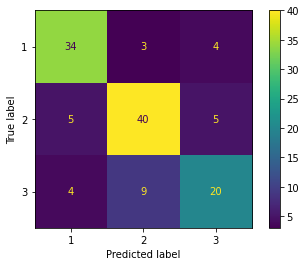

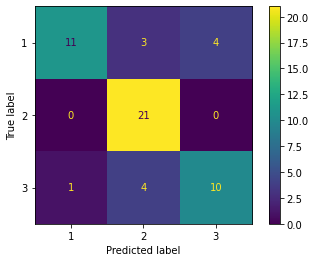

In [ ]:
from sklearn.metrics import plot_confusion_matrix

print('Evaluation of training dataset')
# 精度
print('accuracy', lr.score(X_train_std[:,:2], y_train))
# confusion matrix
plot_confusion_matrix(lr, X_train_std[:,:2], y_train)

print('Evaluation of test dataset')
# 精度
print('accuracy', lr.score(X_test_std[:,:2], y_test))
# confusion matrix
plot_confusion_matrix(lr, X_test_std[:,:2], y_test)

もともとの特徴量を 2 つだけ使った場合、精度はかなり下がる。
これと比べると、PCA によって特徴抽出した 2 つの主成分を使った場合には、精度がかなり高いことがわかる。

## まとめ

主成分分析により以下のタスクを行うことができる。

- 次元削減
  - データを格納するためのメモリやディスク使用量を削減できる
  - 学習アルゴリズムを高速化できる
- 可視化
  - 多数の特徴量（次元）をもつデータを2次元などの理解しやすい空間に落とし込んで議論、解釈することができる。
  
しかし、機械学習の前処理として利用する場合には、以下のことに注意する必要がある。

- 次元削減を行うことによって、多少なりとも情報が失われている
- まずは、すべての特徴量を使ってトレーニングを試すことが大事  
- 次元削減によってオーバーフィッティングを防ぐことができるが、次元削減を使う前に正則化を使うべし
- 上記を試してから、それでも望む結果を得られない場合、次元削減を使う
- 機械学習のトレーニングでは、通常は、99% の累積寄与率が得られるように削減後の次元数を選ぶことが多い  

参考) [Andrew Ng先生の講義](https://www.coursera.org/learn/machine-learning)

## References

1. *Python Machine Learning 2nd Edition* by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2017. Code Repository: https://github.com/rasbt/python-machine-learning-book-2nd-edition
1.  [Andrew Ng先生の講義](https://www.coursera.org/learn/machine-learning)